In [1]:
import torch
from torch.autograd import Function
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torchvision
import glob
from PIL import Image
import gc
import pickle
import os
import math
from scipy.stats import spearmanr

In [2]:
def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:n_max_synsets]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    return wids

def top5accuracy(true, predicted):
    """
    Function to predict the top 5 accuracy
    """
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error


def get_ranks(true, predicted):
    assert len(true) == len(predicted)
    ranks = []
    for i,row in enumerate(predicted):
        ranks.append((np.asarray(row)==true[i]).nonzero()[0].item())
    return ranks

def mean_rank_deficit(original_ranks, predicted_ranks):
    """
    Average number of ranks the correct class dropped in predicted ranks compared with
    the true or original ranks. If ranks improved, we can't say anything about the lesion
    so we just return zero which means that no deficit occured.
    """
    assert len(original_ranks) == len(predicted_ranks)
    diff = np.asarray(predicted_ranks,dtype=float)-np.asarray(original_ranks,dtype=float)
    diff[diff < 0] = 0 # If the model improves we count that as no deficit
    return np.mean(diff)

class HookedModel(torch.nn.Module):
    """
    Constructs a model for applying forward hooks.
    Interface:
        1. Choose model
        2. Choose layer
        3. Choose mask
        4. Apply mask
        5. Evaluate model
        6. Remove mask
    """
    def __init__(self,model):
        super(HookedModel,self).__init__()
        self.model = model
        self.hooks = []
    
    def forward(self,*args,**kwargs):
        return self.model(*args,**kwargs)

    def apply_hook(self,layer_name,hook):
        self.hooks.append(
            get_module(self.model,layer_name).register_forward_hook(hook)
        )

    def remove_hooks(self):
        for _ in range(len(self.hooks)):
            hook = self.hooks.pop()
            hook.remove()


class OutputMaskHook:
    """
    Hook for applying elementwise mask to output of layer.
    """
    def __init__(self,mask):
        self.mask = mask

    def __call__(self, model, input, output):
        output = torch.mul(output, self.mask) # Elementwise multiplication
        return output

def get_module(model, name):
    """
    Finds the named module within the given model.
    Courtesy of https://github.com/kmeng01/rome/blob/main/util/nethook.py#L355
    """
    for n, m in model.named_modules():
        if n == name:
            return m
    raise LookupError(name)

def activation_to_magnitude(coordinates):
    """
    Magnitude is proportional to the sum of animate and inanimate activations
    
    dot([x,y],[1,1]) / norm([1,1])
    """
    magnitude = np.sum(coordinates,axis=1)/np.sqrt(2)
    return magnitude 


def activation_to_selectivity(coordinates):
    """
    Selectivity is proportional to Animate - Inanimate activations
    
    dot([x,y],[-1,1]) / norm([-1,1])
    """
    selectivity = (coordinates[:,0] - coordinates[:,1])/np.sqrt(2)
    return selectivity


def grid_space(x,y,y_partitions=28,x_partitions=28,symmetric=False):
    """
    Takes in set of coordinates in 2D space and returns geopandas.GeoDataFrame
    where each entry represents a single cell in the grid space with an equal number
    of units. Symmetric grids don't necessarily have the same number of units per cell.
    
    Parameters
    ----------
        x (1D list) : List of x coordinates
        y (1D list) : List of y coordinates
        y_partitions: Number of partitions in Y direction, should be even number so that
                      cells can be symmetrical around zero
        x_partitions: Number of partitions in X direction, should be even number so that
                      cells can be symmetrical around zero
        symmetric (bool): Whether or not to make it symmetric around zero
                      
    Returns
    -------
        geopandas.GeoDataFrame : one entry per cell in grid starting at bottom left and going right
        
    """
    if symmetric:
        y_neg_sorted = np.sort(y[y<0])
        y_pos_sorted = np.sort(y[y>0])

        # First half of bounds come from negative region, second from positive
        y_bounds = ([y_neg_sorted[int(((2*i)/y_partitions)*len(y_neg_sorted))] 
                         for i in range(int(y_partitions/2))] + [0] +
                    [y_pos_sorted[int(((2*i)/y_partitions)*len(y_pos_sorted))] 
                         for i in range(1,int(y_partitions/2))] + [y_pos_sorted[-1]])
    else:
        y_sorted = np.sort(y)
        y_bounds = ([y_sorted[math.floor((i/y_partitions)*len(y_sorted))] 
                         for i in range(y_partitions)] + [y_sorted[-1]])

    grid_cells = []
    
    for i,y_lower_bound in enumerate(y_bounds[:-1]):
        y_upper_bound = y_bounds[i+1]
        
        if symmetric:
            # Only look at x coordinates which fall within vertical (y direction) strip of interest
            x_neg_sorted = np.sort(x[(y > y_lower_bound) & (y < y_upper_bound) & (x < 0)])
            x_pos_sorted = np.sort(x[(y > y_lower_bound) & (y < y_upper_bound) & (x > 0)])

            # First half of bounds come from negative region, second from positive
            x_bounds = ([x_neg_sorted[int(((2*k)/x_partitions)*len(x_neg_sorted))] 
                             for k in range(int(x_partitions/2))] + [0] +
                        [x_pos_sorted[int(((2*k)/x_partitions)*len(x_pos_sorted))] 
                             for k in range(1,int(x_partitions/2))] + [x_pos_sorted[-1]])
        else:
            x_sorted = np.sort(x[(y > y_lower_bound) & (y < y_upper_bound)])
            x_bounds = ([x_sorted[int((k/x_partitions)*len(x_sorted))] 
                             for k in range(x_partitions)] + [x_sorted[-1]])
        
        # Add bounds to list
        for j,x_lower_bound in enumerate(x_bounds[:-1]):
            x_upper_bound = x_bounds[j+1]
            # grid_cells.append(shapely.geometry.box(x_lower_bound, y_lower_bound, 
            #                                        x_upper_bound, y_upper_bound))
            grid_cells.append([x_lower_bound, y_lower_bound, 
                               x_upper_bound, y_upper_bound])
    
    # I don't know what this CRS projection is...
    # crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # return geopandas.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

    return grid_cells

In [3]:
classes = ['schooner','brain_coral','junco_bird','snail','grey_whale','siberian_husky','electric_fan','bookcase','fountain_pen','toaster']


dfs = []
for cl in classes:
    d = pd.read_csv('../data/experiments/iclr_results_'+cl+'_mps.csv',index_col=0)
    dfs.append(d)

    d = pd.read_csv('../data/experiments/iclr_results_'+cl+'_first_layers.csv',index_col=0)
    dfs.append(d)

    d = pd.read_csv('../data/experiments/iclr_results_'+cl+'.csv',index_col=0)
    dfs.append(d)

d = pd.concat(dfs)

In [4]:
d['layer'].unique()

array(['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1',
       'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2',
       'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1',
       'layer4.2'], dtype=object)

In [5]:
d.to_csv('../data/experiments/iclr_results_master.csv')

In [6]:
d['layer'].unique()

array(['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1',
       'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2',
       'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1',
       'layer4.2'], dtype=object)

In [13]:
d = pd.read_csv('../data/experiments/iclr_results_master.csv',index_col=0)

In [7]:
for a in ['decoding_accuracy_delta','ablation_impact']:
    for b in ['cka', 'procrustes','pwcca', 'mean_sq_cca_corr', 'mean_cca_corr']:
        df = pd.DataFrame([],columns=['class','layer','correlation','pvalue'])
        for cl in d['class'].unique():
            for layer in d['layer'].unique():
                data = d[(d['class']==cl) & (d['layer']==layer)]
                corr,p = spearmanr(data[a],data[b])
                df.loc[len(df)] = [cl,layer,corr,p]
        df.to_csv('../data/experiments/resnet50_'+a+'_X_'+b+'.csv')

In [26]:
d[(d['class']==classes[0]) & (d['layer']==layers[0])]

,class,layer,tile,decoding_accuracy_delta,regularized_decoding_accuracy,ablation_impact,cka,procrustes,pwcca,mean_sq_cca_corr,mean_cca_corr
0,schooner,encoder.layers.encoder_layer_0,0,-0.262716,0.34,139.08,0.131366,0.048820,0.335492,0.403575,0.620655
1,schooner,encoder.layers.encoder_layer_0,1,-0.051592,0.26,321.26,0.129247,0.038593,0.371744,0.362221,0.588581
2,schooner,encoder.layers.encoder_layer_0,2,-0.005847,0.31,256.48,0.136942,0.042650,0.392409,0.338484,0.567730
3,schooner,encoder.layers.encoder_layer_0,3,-0.058081,0.29,354.26,0.135191,0.053938,0.359716,0.373101,0.594471
4,schooner,encoder.layers.encoder_layer_0,4,0.038859,0.04,470.82,0.117733,0.070713,0.582259,0.161389,0.378549
5,schooner,encoder.layers.encoder_layer_0,5,0.038859,0.03,586.08,0.248796,0.118507,0.685399,0.094782,0.284539
6,schooner,encoder.layers.encoder_layer_0,6,0.038859,0.05,553.40,0.250019,0.112281,0.673245,0.101402,0.296234
7,schooner,encoder.layers.encoder_layer_0,7,0.038859,0.06,375.76,0.114889,0.070571,0.582726,0.161034,0.378467
8,schooner,encoder.layers.encoder_layer_0,8,0.038859,0.06,367.00,0.109656,0.069008,0.581627,0.161978,0.379376
9,schooner,encoder.layers.encoder_layer_0,9,0.038859,0.09,578.30,0.238037,0.114413,0.681933,0.096511,0.287639


In [19]:
d.groupby('tile')['ablation_impact'].mean()

tile
0     174.365333
1     272.654333
2     296.253833
3     272.641333
4     289.421500
5     321.612000
6     322.600333
7     288.383833
8     299.625833
9     322.738833
10    319.875833
11    284.168000
12    271.885833
13    299.348167
14    271.383500
15    163.010833
Name: ablation_impact, dtype: float64

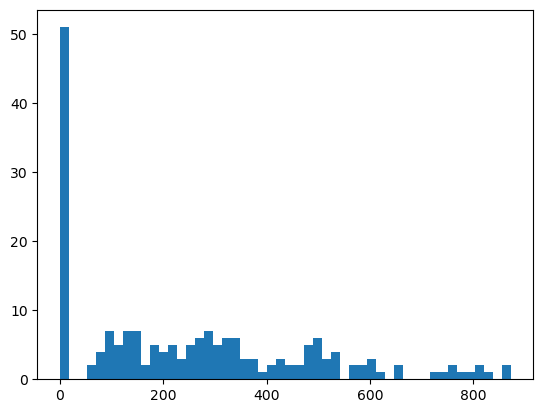

In [15]:
plt.hist(d['ablation_impact'],bins=50)
plt.show()

In [3]:
data_path = '../data/'

# Load model
model = torchvision.models.vit_b_16(weights='DEFAULT').to('cuda:0')
layers = [n for n,m in model.named_modules() if isinstance(m,torchvision.models.vision_transformer.EncoderBlock)]

#Load the details of all the 1000 classes and the function to convert the synset id to words
meta_clsloc_file = data_path+'meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

#Code snippet to load the ground truth labels to measure the performance
truth = {}
with open(data_path+'ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1

# Get list of all images
im_valid_test = glob.glob(data_path+'images/*')
im_valid_test = np.asarray(im_valid_test)

# Make list of wids
true_valid_wids = []
for i in im_valid_test:
    temp1 = i.split('/')[-1]
    temp = temp1.split('.')[0].split('_')[-1]
    true_valid_wids.append(truth[int(temp)][1])
true_valid_wids = np.asarray(true_valid_wids)

In [4]:
images = []
for im in im_valid_test:
    im_temp = Image.open(im).convert('RGB')
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1.transforms(),
    ])
    im_temp = preprocess(im_temp)
    images.append(im_temp)

images = torch.stack(images).to('cuda:0')

with torch.no_grad():
    out = model(images).cpu().numpy()

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    predicted_valid_wids.append(pprint_output(out[i],1000))
predicted_valid_wids = np.asarray(predicted_valid_wids)

# Count errors and save baseline ranks
count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
baseline_ranks  = np.asarray(get_ranks(true_valid_wids,predicted_valid_wids))

print (baseline_ranks.shape)
print('baseline '+str(count)+' '+str(len(true_valid_wids))+' '+str(error)+' '+str(1-error))

del model
gc.collect()

/home/snag-lab/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(500,)
baseline 486 500 0.028000000000000025 0.972


9

In [5]:
classes = ['schooner','brain_coral','junco_bird','snail','grey_whale','siberian_husky','electric_fan','bookcase','fountain_pen','toaster']
class_wids = ['n04147183','n01917289','n01534433','n01944390','n02066245','n02110185','n03271574','n02870880','n03388183','n04442312']

class_idx = 0
c = classes[class_idx]

unit_activations = {l:[] for l in layers}
for im in im_valid_test:
    wid = im.split('/')[-1].split('.')[0].split('_')[-1]
    with open(os.path.join(data_path,'activations',wid+'.pkl'), 'rb') as f:
        activations = pickle.load(f)
        for l in layers:
            unit_activations[l].append(activations[l][:,1:,:].flatten())

unit_activations = {l:np.row_stack(unit_activations[l]) for l in layers}
print(unit_activations[layers[0]].shape)

class_indexes = [idx for idx in range(len(true_valid_wids)) if true_valid_wids[idx]==class_wids[class_idx]]
other_indexes = [idx for idx in range(len(true_valid_wids)) if true_valid_wids[idx]!=class_wids[class_idx]]
class_activations = {l:np.mean(unit_activations[l][class_indexes],axis=0) for l in layers}
other_activations = {l:np.mean(unit_activations[l][other_indexes],axis=0) for l in layers}

X = {l:np.column_stack((class_activations[l],other_activations[l])) for l in layers}

print(X[layers[0]].shape)

(500, 150528)
(150528, 2)


In [18]:
layer = 'encoder.layers.encoder_layer_10'

magnitude = activation_to_magnitude(X[layer])
selectivity = activation_to_selectivity(X[layer])

print ('generating grid')
x_partitions,y_partitions = 2,2
cell = grid_space(magnitude,selectivity,x_partitions=x_partitions,y_partitions=y_partitions)

# Don't have access to geopandas in python 2.7, so we're brute forcing unit assignments to cells.
units_in_cells = dict()
for cell_index in range(len(cell)):
    units_in_cells[cell_index] = []
    for unit_index in range(len(magnitude)):
        if (magnitude[unit_index] >= cell[cell_index][0] and
            selectivity[unit_index] >= cell[cell_index][1] and
            magnitude[unit_index] <= cell[cell_index][2] and
            selectivity[unit_index] <= cell[cell_index][3]):
            units_in_cells[cell_index].append(unit_index)
    print (len(units_in_cells[cell_index]),
            min(units_in_cells[cell_index]),
            max(units_in_cells[cell_index]))

generating grid
37633 5 150526
37632 25 150522
37633 0 150527
37631 2 150518


In [19]:
for bbx in range(len(cell)):
    # Query indices of units in that cell, create mask and set activations to zero
    loc_new = units_in_cells[bbx]
    # loc_new = np.random.choice(np.arange(768),size=750,replace=False)
    lambda_mask = np.ones(shape=((len(magnitude),)),dtype=np.float32)

    lambda_mask[loc_new] = 1.
    lambda_mask = np.row_stack((np.zeros(768,dtype=np.float32),lambda_mask.reshape(196,768)))
    print('Cell: ', bbx, ' Units: ', len(loc_new))

    model = torchvision.models.vit_b_16(weights='DEFAULT')
    hooked_model = HookedModel(model).to('cuda:0')
    mask_hook = OutputMaskHook(torch.from_numpy(lambda_mask).to('cuda:0'))
    hooked_model.apply_hook(layer,mask_hook)

    with torch.no_grad():
        out = hooked_model(images).cpu().numpy()

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        predicted_valid_wids.append(pprint_output(out[i],1000))
    predicted_valid_wids = np.asarray(predicted_valid_wids)

    # calculate ranks
    count, error  = top5accuracy(true_valid_wids[class_indexes], predicted_valid_wids[class_indexes])
    class_ranks  = get_ranks(true_valid_wids[class_indexes],
                            predicted_valid_wids[class_indexes])
    other_ranks  = get_ranks(true_valid_wids[other_indexes],
                            predicted_valid_wids[other_indexes])
    class_mrd = mean_rank_deficit(baseline_ranks[class_indexes],class_ranks)
    other_mrd = mean_rank_deficit(baseline_ranks[other_indexes],other_ranks)

    print(class_mrd,other_mrd)
    print(c+' '+str(count)+' '+str(len(class_indexes))+' '+str(error)+' '+str(1-error))

    del hooked_model
    del model
    gc.collect()

Cell:  0  Units:  37633
363.1 847.9155555555556
schooner 16 50 0.6799999999999999 0.32000000000000006
Cell:  1  Units:  37632
363.1 847.9155555555556
schooner 16 50 0.6799999999999999 0.32000000000000006
Cell:  2  Units:  37633
363.1 847.9155555555556
schooner 16 50 0.6799999999999999 0.32000000000000006
Cell:  3  Units:  37631
363.1 847.9155555555556
schooner 16 50 0.6799999999999999 0.32000000000000006


In [11]:
with open(os.path.join('../data/','activations','00000011.pkl'), 'rb') as f:
    activations = pickle.load(f)

In [13]:
activations['encoder.layers.encoder_layer_0'].shape

(1, 197, 768)

In [5]:
def rls(X,Y,penalty=0):
    return (torch.linalg.inv(
                X.T @ X + penalty * X.shape[0] * torch.eye(X.shape[1],dtype=X.dtype,device=X.device)) 
            @ X.T @ Y)

def acc(X,Y,W):
    predictions = torch.argmax(X @ W, 1)
    labels = torch.argmax(Y, 1)
    return torch.count_nonzero(predictions==labels)/len(predictions)

In [19]:
model = torchvision.models.vit_b_16(weights='DEFAULT')
layers = [n for n,m in model.named_modules() if isinstance(m,torchvision.models.vision_transformer.EncoderBlock)]
del model

# Get list of all images
im_valid_test = glob.glob('../data/images/*')
im_valid_test = np.asarray(im_valid_test)

unit_activations = {l:[] for l in layers}
for im in im_valid_test:
    wid = im.split('/')[-1].split('.')[0].split('_')[-1]
    with open(os.path.join('../data/','activations',wid+'.pkl'), 'rb') as f:
        activations = pickle.load(f)
        for l in layers:
            unit_activations[l].append(activations[l])

unit_activations = {l:np.row_stack(unit_activations[l]) for l in layers}
print(unit_activations[layers[0]].shape)

(500, 197, 768)


In [25]:
wid_to_label = dict(zip(np.unique(true_valid_wids),np.arange(10)))
labels = np.asarray([np.zeros(10)-1 for w in true_valid_wids])
for i,w in enumerate(true_valid_wids):
    labels[i,wid_to_label[w]] = 1

In [49]:
accs = []
for layer in range(12):
    X = torch.from_numpy(unit_activations[layers[layer]][:400,0,:]).squeeze()
    Y = torch.from_numpy(labels[:400]).float()
    W = rls(X,Y,100)

    X_test = torch.from_numpy(unit_activations[layers[layer]][400:,0,:]).squeeze()
    Y_test = torch.from_numpy(labels[400:]).float()
    accs.append(acc(X_test,Y_test,W).numpy())

In [50]:
accs

[array(0.07, dtype=float32),
 array(0.07, dtype=float32),
 array(0.1, dtype=float32),
 array(0.12, dtype=float32),
 array(0.12, dtype=float32),
 array(0.15, dtype=float32),
 array(0.27, dtype=float32),
 array(0.53, dtype=float32),
 array(0.96, dtype=float32),
 array(0.99, dtype=float32),
 array(1., dtype=float32),
 array(0.99, dtype=float32)]

In [2]:
X = torch.from_numpy(np.random.randn(500,15052)).float().to('cuda')
Y = torch.from_numpy(np.random.randint(0,2,(500,10))).float().to('cuda')

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [11]:
%%timeit
w = rls(X,Y,10)

10.5 ms ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
w = rls(X,Y,10)

In [5]:

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return (2*np.eye(num_classes)-1)[y]

to_categorical(np.random.randint(0,2,10),2)

array([[ 1., -1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [ 1., -1.]])